In [1]:
import torch
torch.cuda.empty_cache()


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # WordNet dependencies


[nltk_data] Downloading package punkt to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Angelika
[nltk_data]     Vergara\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import nltk
nltk.data.path.append("C:/Users/Angelika Vergara/AppData/Roaming/nltk_data")
nltk.download('punkt', download_dir="C:/Users/Angelika Vergara/AppData/Roaming/nltk_data")


[nltk_data] Downloading package punkt to C:/Users/Angelika
[nltk_data]     Vergara/AppData/Roaming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import nltk
print(nltk.data.path)  # Check where NLTK is looking for data


['C:\\Users\\Angelika Vergara/nltk_data', 'c:\\Users\\Angelika Vergara\\AppData\\Local\\Programs\\Python\\Python312\\nltk_data', 'c:\\Users\\Angelika Vergara\\AppData\\Local\\Programs\\Python\\Python312\\share\\nltk_data', 'c:\\Users\\Angelika Vergara\\AppData\\Local\\Programs\\Python\\Python312\\lib\\nltk_data', 'C:\\Users\\Angelika Vergara\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [4]:
import nltk
nltk.data.path.append("C:/Users/Angelika Vergara/AppData/Roaming/nltk_data")


In [2]:
text = "This is a test comment!"
tokens = text.split()
print(tokens)


['This', 'is', 'a', 'test', 'comment!']


In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")
tokens = [token.text for token in nlp("This is a test comment!")]
print(tokens)


['This', 'is', 'a', 'test', 'comment', '!']


In [5]:
%pip install spacy
!python -m spacy download en_core_web_sm


Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 364.6 kB/s eta 0:00:34
     -- ------------------------------------ 0.8/12.8 MB 541.1 kB/s eta 0:00:23
     -- ------------------------------------ 0.8/12.8 MB 541.1 kB/s eta 0:00:23
     --- ----------------------------------- 1

c:\Users\Angelika Vergara\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 183s 97ms/step - accuracy: 0.7186 - loss: 0.5449 - val_accuracy: 0.6739 - val_loss: 0.5859
Epoch 2/5
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 186s 99ms/step - accuracy: 0.7915 - loss: 0.4947 - val_accuracy: 0.8409 - val_loss: 0.4002
Epoch 3/5
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 188s 101ms/step - accuracy: 0.8384 - loss: 0.3802 - val_accuracy: 0.9002 - val_loss: 0.2511
Epoch 4/5
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 200s 107ms/step - accuracy: 0.9020 - loss: 0.2523 - val_accuracy: 0.9062 - val_loss: 0.2330
Epoch 5/5
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 196s 105ms/step - accuracy: 0.9076 - loss: 0.2384 - val_accuracy: 0.9089 - val_loss: 0.2241
Training Time: 954.05 seconds
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.89      0.93      0.91      3685
       Toxic       0.93      0.89      0.91      3684

    accuracy                           0.91      7369
   macro avg       0.91

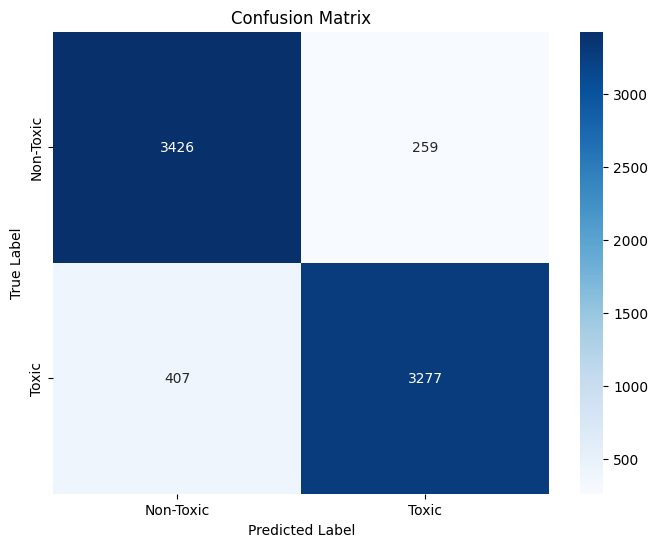

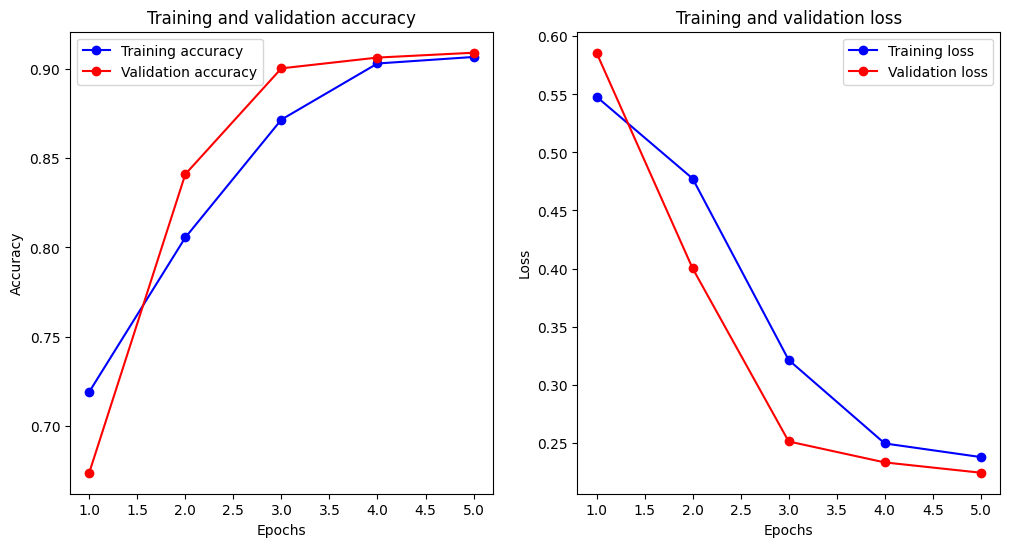

Estimated Time Complexity: O(172907334)


In [1]:
import numpy as np
import pandas as pd
import re
import spacy
import pickle
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load SpaCy model (en_core_web_md has 300d vectors)
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

def load_and_balance_datasets():
    """Load and balance datasets to match paper's methodology."""
    kaggle_df = pd.read_csv('./data/train.csv')
    kaggle_df['toxic'] = kaggle_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
    kaggle_df = kaggle_df[['comment_text', 'toxic']]

    davidson_df = pd.read_csv('./data/labeled_data.csv')
    davidson_df['toxic'] = (davidson_df['class'] != 2).astype(int)
    davidson_df = davidson_df[['tweet', 'toxic']]
    davidson_df = davidson_df.rename(columns={'tweet': 'comment_text'})

    combined_df = pd.concat([kaggle_df, davidson_df], ignore_index=True)

    # **Balance dataset: Keep 1:1 ratio between toxic and non-toxic**
    df_majority = combined_df[combined_df.toxic == 0]
    df_minority = combined_df[combined_df.toxic == 1]

    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),  # Match 1:1 ratio for balance
        random_state=42
    )

    balanced_df = pd.concat([df_majority_downsampled, df_minority]).reset_index(drop=True)
    return balanced_df

def clean_text(text):
    """Preprocess text by lowercasing, removing special characters, and handling contractions."""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+|@\w+|#", "", text)  # Remove URLs and mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces

    # Handle contractions
    contractions = {
        "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is",
        "'d": " would", "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
    }
    for key, val in contractions.items():
        text = text.replace(key, val)

    return text

def preprocess_texts(texts):
    """Tokenize and lemmatize texts using spaCy."""
    cleaned_texts = [clean_text(text) for text in texts]

    processed_texts = []
    for doc in nlp.pipe(cleaned_texts, batch_size=500):
        processed_texts.append(" ".join([token.lemma_ for token in doc if not token.is_stop]))

    return processed_texts

def prepare_model_input(df):
    """Prepare data for model training using spaCy word vectors."""
    df['processed_text'] = preprocess_texts(df['comment_text'].tolist())

    # Extract unique words for tokenization
    unique_words = set(word for text in df['processed_text'] for word in text.split())
    tokenizer = {word: i+1 for i, word in enumerate(unique_words)}

    # Convert texts to sequences
    sequences = [[tokenizer.get(word, 0) for word in text.split()] for text in df['processed_text']]
    padded_sequences = pad_sequences(sequences, maxlen=128, padding='post', truncating='post')

    # Create embedding matrix using spaCy vectors
    vocab_size = len(tokenizer) + 1
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.items():
        embedding_matrix[i] = nlp(word).vector if word in nlp.vocab else np.zeros(300)  # Handle OOV words

    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, df['toxic'], test_size=0.1, stratify=df['toxic'], random_state=42
    )

    return X_train, X_test, y_train, y_test, tokenizer, embedding_matrix, vocab_size

def build_model(vocab_size, embed_dim=300, embedding_matrix=None):
    """Build an optimized LSTM model using spaCy embeddings."""
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=128,
                  weights=[embedding_matrix] if embedding_matrix is not None else None, trainable=False),
        SpatialDropout1D(0.2), # Reduced dropout
        LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),  # Add recurrent dropout and reduced dropout
        Dense(128, activation='relu'),
        Dropout(0.4), #Reduced dropout
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Lower LR for stability
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_confusion_matrix(y_true, y_pred, class_names, title=None):
    """Plots a confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    if title is None:
        title = "Confusion Matrix"

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

def plot_training_history(history):
    """Plots training accuracy and loss per epoch."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def calculate_and_print_metrics(model, X_test, y_test, class_names):
    """Calculates and prints the classification report, confusion matrix, and other metrics."""
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    plot_confusion_matrix(y_test, y_pred, class_names=class_names)

def calculate_time_complexity(model, input_shape):
    """Estimates the time complexity of the model (very rough approximation)."""
    # This is a simplified estimate.  Actual time complexity can vary based on hardware,
    # software, and specific operations.  For a more precise analysis, profiling tools
    # should be used.
    num_layers = len(model.layers)
    total_params = model.count_params()
    
    # Very basic approximation - O(number of layers * number of parameters)
    # This doesn't account for the complexity of individual layers (e.g., LSTM is more complex than Dense)
    time_complexity = num_layers * total_params  

    return time_complexity

def main():
    df = load_and_balance_datasets()
    X_train, X_test, y_train, y_test, tokenizer, embedding_matrix, vocab_size = prepare_model_input(df)

    model = build_model(vocab_size, embed_dim=300, embedding_matrix=embedding_matrix)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y_train),
                                                     y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=5,  # Fine-tuned epochs
        batch_size=32,  #Fine-tuned batch size
        verbose=1,
        callbacks=[early_stopping],
        class_weight=class_weight_dict #Use class weights
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time: {training_time:.2f} seconds")

    # Convert TensorFlow/Keras model to PyTorch and save
    class SimpleModel(torch.nn.Module):
        def __init__(self, keras_model):
            super(SimpleModel, self).__init__()
            self.keras_model = keras_model

        def forward(self, x):
            # Keras expects a batch dimension, but PyTorch might not always provide it
            if len(x.shape) == 2:
                x = x.unsqueeze(0)  # Add batch dimension if missing
            x = self.keras_model(x).squeeze()  # Remove unnecessary dimensions
            return torch.sigmoid(torch.tensor(x))  # Ensure output is a sigmoid

    # Wrap the Keras model
    pytorch_model = SimpleModel(model)

    # Save the PyTorch model
    torch.save(pytorch_model.state_dict(), "baseline_unbalanced.pth")
    
    with open("tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    class_names = ['Non-Toxic', 'Toxic']  # Define class names
    calculate_and_print_metrics(model, X_test, y_test, class_names=class_names)

    # Plot training history
    plot_training_history(history)

    # Calculate and print time complexity
    input_shape = (None, 128)  # Adjust based on your input sequence length
    time_complexity = calculate_time_complexity(model, input_shape)
    print(f"Estimated Time Complexity: O({time_complexity})")

if __name__ == "__main__":
    main()
